In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

# Set parameters
base_dir = r"C:\Users\rishi\OneDrive\Desktop\Amrita\S7\Deep Learning and Computer Vision\Forest Fire Detection\lab2_dataset"
img_height, img_width = 150, 150
batch_size = 32
num_classes = 4 # Update based on your classes

In [2]:
# Load dataset
classes = ['smokefire','smoke','nofire','fire']
data = []
labels = []
for label in classes:
    folder_path = os.path.join(base_dir, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(img_height, img_width))
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            data.append(img_array)
            labels.append(classes.index(label))

data = np.array(data)
labels = np.array(labels)


In [3]:
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Data shape: (800, 150, 150, 3)
Labels shape: (800,)


In [4]:

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Unfreeze the entire model initially

# Add custom layers on top of InceptionV3
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)  # Increased layer size
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # Additional dense layer
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)  # Lower learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,  # Increased epochs
                    verbose=1)

Epoch 1/10
20/20 [==============================] - 10s 229ms/step - loss: 0.3260 - accuracy: 0.8875 - val_loss: 0.6636 - val_accuracy: 0.8938
Epoch 2/10
20/20 [==============================] - 4s 181ms/step - loss: 0.3552 - accuracy: 0.8859 - val_loss: 0.6455 - val_accuracy: 0.9000
Epoch 3/10
20/20 [==============================] - 4s 181ms/step - loss: 0.4124 - accuracy: 0.8562 - val_loss: 0.6914 - val_accuracy: 0.9000
Epoch 4/10
20/20 [==============================] - 4s 181ms/step - loss: 0.2857 - accuracy: 0.8984 - val_loss: 0.4985 - val_accuracy: 0.9062
Epoch 5/10
20/20 [==============================] - 4s 181ms/step - loss: 0.2162 - accuracy: 0.9109 - val_loss: 0.5397 - val_accuracy: 0.9125
Epoch 6/10
20/20 [==============================] - 4s 181ms/step - loss: 0.2391 - accuracy: 0.9125 - val_loss: 0.4186 - val_accuracy: 0.9062
Epoch 7/10
20/20 [==============================] - 4s 181ms/step - loss: 0.2371 - accuracy: 0.9172 - val_loss: 0.3305 - val_accuracy: 0.9062
Epoch

In [8]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {loss:.4f}")


Validation Accuracy: 0.9125
Validation Loss: 0.5184


Classification Report:
              precision    recall  f1-score   support

   smokefire       0.82      1.00      0.90        40
       smoke       1.00      0.80      0.89        40
      nofire       0.93      0.95      0.94        40
        fire       0.95      0.90      0.92        40

    accuracy                           0.91       160
   macro avg       0.92      0.91      0.91       160
weighted avg       0.92      0.91      0.91       160



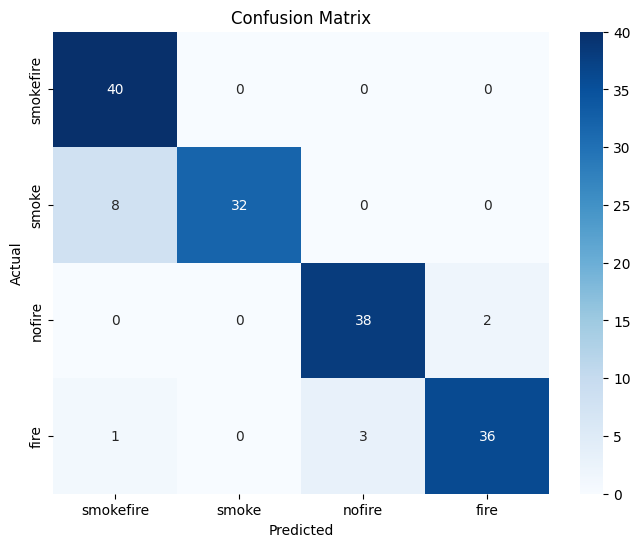

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the labels for the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=classes))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


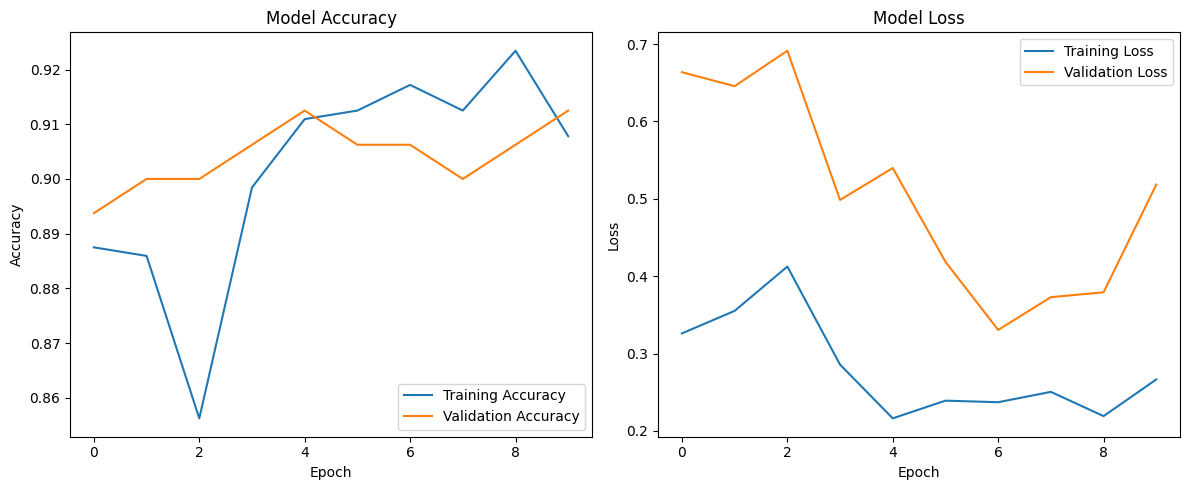

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


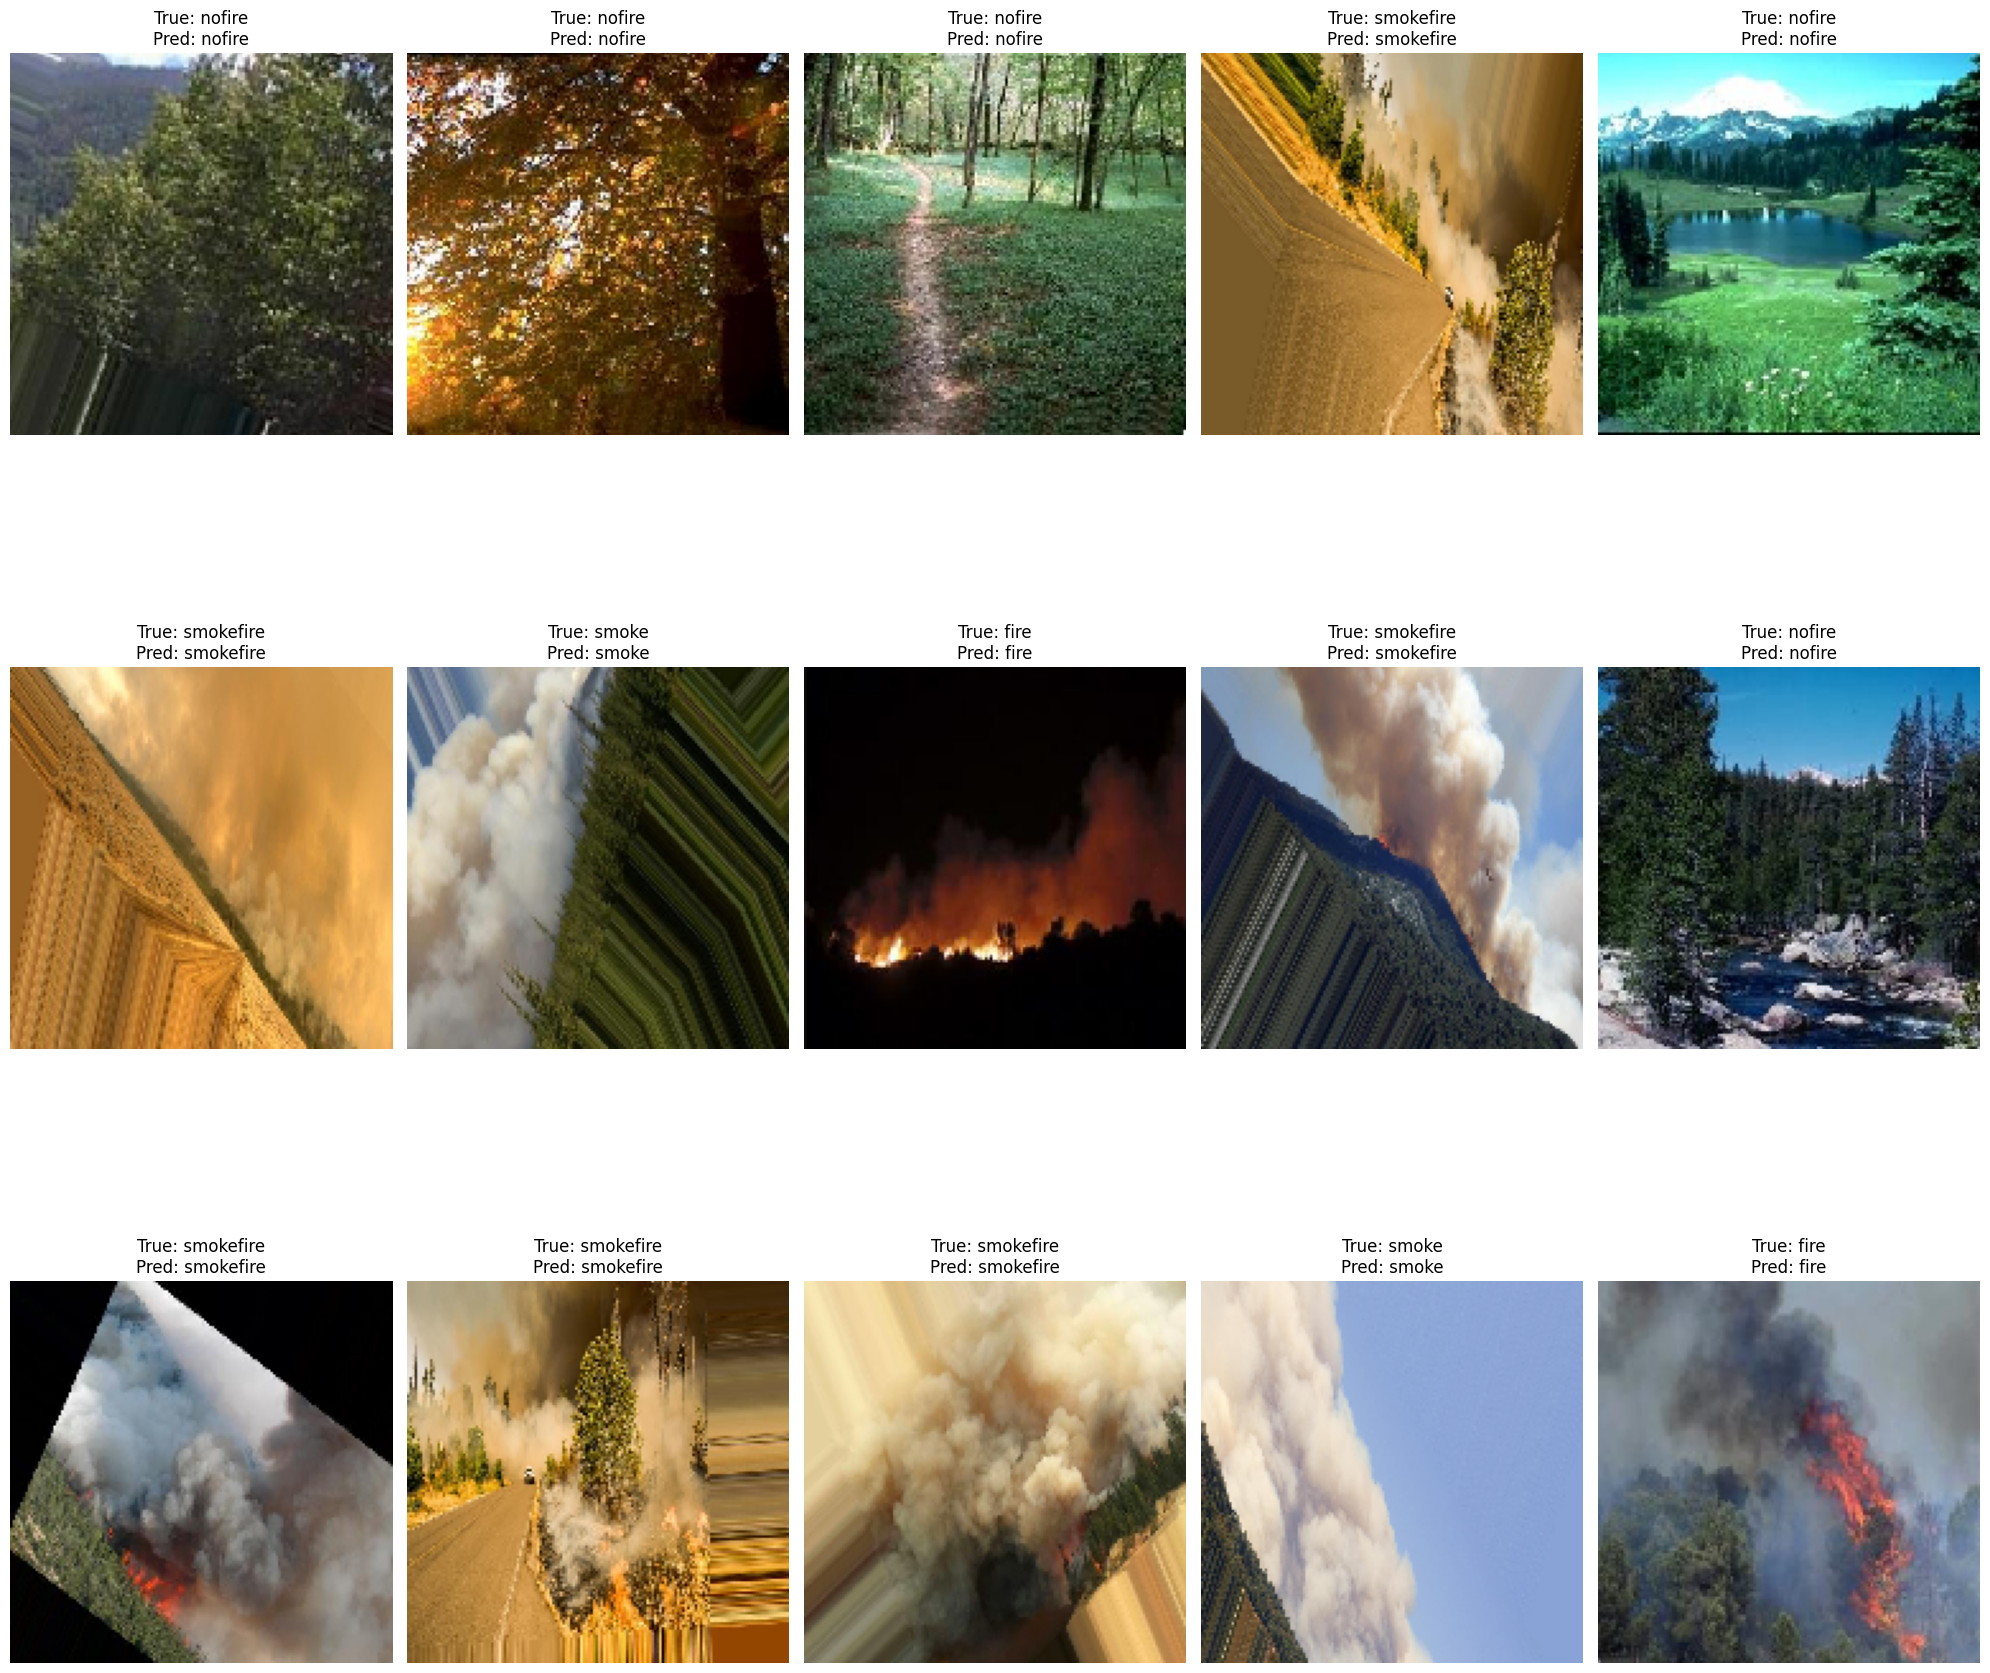

In [11]:
import random
import matplotlib.pyplot as plt

# Function to predict and visualize random images
def predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15):
    # Select random images from the base directory
    random_images = []
    for _ in range(num_images):
        random_class = random.choice(classes)
        folder_path = os.path.join(base_dir, random_class)
        random_file = random.choice(os.listdir(folder_path))
        img_path = os.path.join(folder_path, random_file)
        random_images.append((img_path, random_class))

    # Plot the images with predictions
    plt.figure(figsize=(20, 20))
    for i, (img_path, true_class) in enumerate(random_images):
        # Load and preprocess the image
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict the class
        prediction = model.predict(img_array)
        predicted_class = classes[np.argmax(prediction)]

        # Display the image with true and predicted labels
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize 15 predictions
predict_and_visualize_random_images(base_dir, model, img_height, img_width, classes, num_images=15)


In [12]:
import os
print("Model successfully converted and saved as model.tflite.")
print("Current Working Directory:", os.getcwd())


Model successfully converted and saved as model.tflite.
Current Working Directory: c:\Users\rishi\OneDrive\Desktop\dlcv\MAD_GROUP28


In [13]:
model.save('hello.keras')

In [15]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open("mymodel.tflite", 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted and saved as model.tflite.")

INFO:tensorflow:Assets written to: C:\Users\rishi\AppData\Local\Temp\tmpojizv6et\assets


INFO:tensorflow:Assets written to: C:\Users\rishi\AppData\Local\Temp\tmpojizv6et\assets


Model successfully converted and saved as model.tflite.


In [12]:
model.save('forest_fire_model.h5')
